# Single-Cell Velocity Analysis using Alevin, Scanpy, and scVelo

This notebook follows the general procedure outlined in the [2020 Alevin Velocity tutorial published by the COMBINE Lab](https://combine-lab.github.io/alevin-tutorial/2020/alevin-velocity/).

In contrast to normal single-cell RNA-seq analysis which only quantifies spliced transcripts, performing RNA-velocity requires separate quantitation of the expression of intronic sequences in a way that allows comparisons of the ratio of spliced (all exonic) and unspliced (intron containing) transcripts between cells. RNA-velocity tools operate under the assumption that unspliced transcripts represent the possible future of what the transcriptome of a cell will look like. This allows these tools, [scVelo](https://scvelo.readthedocs.io/) in this tutorial, to estimate how cells are changing what genes are expressed by comparing these ratios and reconstructing the potential future cell states by similarity between one cell's projected future state and other cells' current states. 

In order to perform this analysis, first, the transcriptome must be prepared to quantify intronic sequences, this is done by the `PreprocessVelocityTranscriptome` module which parses out the intronic sequences and constructs other supplementary files for various quality control steps. Then the modified transcriptome needs to be indexed with the `Salmon.Indexer` module. This index can then be reused for all samples that were prepared for the same species and sequencing platform. Next, the each sample's genes expression is quantified with `Salmon.alevin.quant`. The resulting alevin quant files are then run through `Convert.alevin` to produce the requisite .h5ad file which separates the spliced and unspliced counts into the structure expected by scVelo. If multiple samples were quantified individually with `Salmon.alevin.quant`, they should be combined at this step. `Convert.alevin` will assign a batch id to each sample under the "batch" key which can then be used to ensure that there are not batch effects in the data and to regress out these effects if they are present. After combining any multiple samples, standard single-cell preprocessing is done with Scanpy. This is done in two steps, first `ScanpyQC` assesses relevant metrics of cell quality, then using the results from this analysis filtering parameters can be set in `ScanpyUtilities`. This filtering removes poor quality cells, selects highly variable genes, and embeds the cells into lower-dimensional space for visualization. The processed, lower-dimensionally embedded, single-cell experiment can then be analyzed in scVelo.

An overview of six steps in the velocity analysis workflow for use with single-cell fastq files can be seen below:

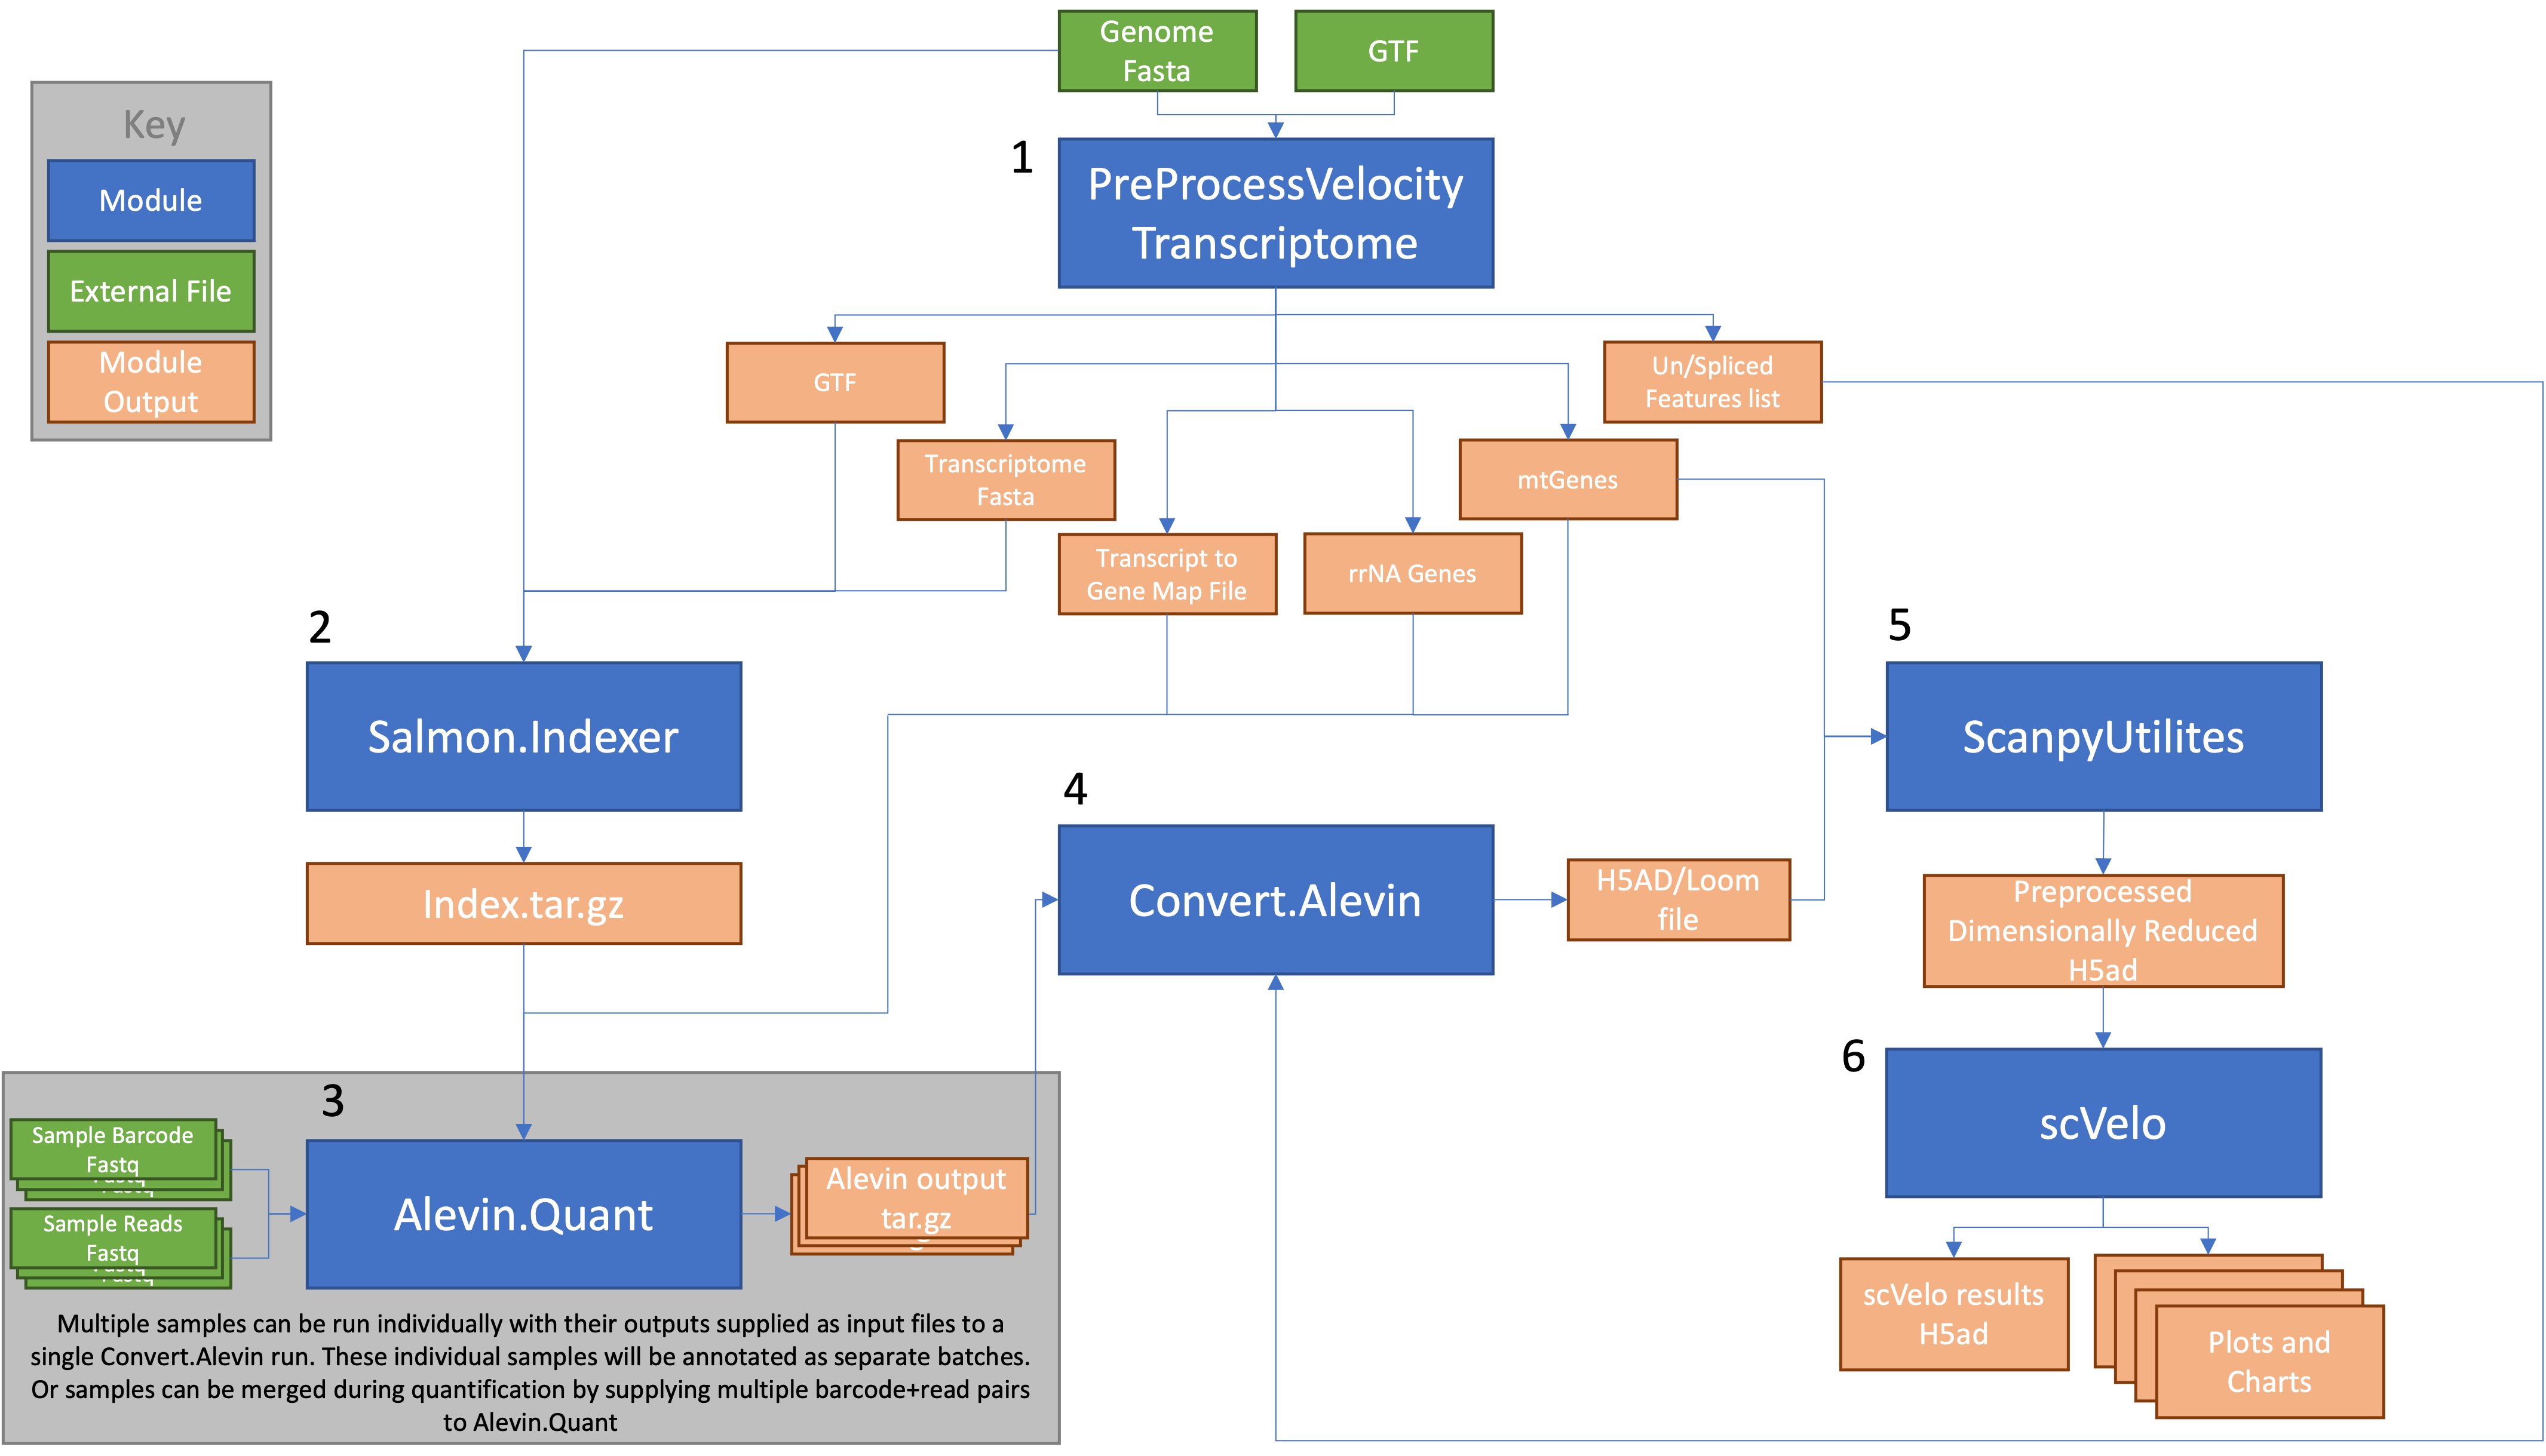

In this tutorial we are going to be recreating the E14.5 mouse pancreatic development trajectory from [Bastidas-Ponce et al. (2009)](https://journals.biologists.com/dev/article/146/12/dev173849/19483/Comprehensive-single-cell-mRNA-profiling-reveals-a) performed using the 10x Chromium v2 Chemistry from the raw [FASTQ files](https://www.ebi.ac.uk/ena/browser/view/SRR9201793?show=reads). 

## Log in to GenePattern Beta

For this workflow all of the modules are still on the beta server, they currently rely on some infrastructure improvements we're working on.

In [14]:
# Requires GenePattern Notebook: pip install genepattern-notebook
import gp
import genepattern

# Username and password removed for security reasons.
genepattern.display(genepattern.session.register("https://beta.genepattern.org/gp", "", ""))

GPAuthWidget()

## Extend the transcriptome to include unspliced sequences

By default, transcriptome datasets only include fully spliced, processed mRNA (cDNA) sequences. In order to run velocity analysis, the transcriptome has to be extended to include the intronic sequences that are normally spliced out by the cell as part of the RNA maturation process. By quantifying both mature, processed, mRNAs and the immature, unprocessed mRNAs separately it then becomes possible to compute the current state (based on mature transcripts), and a prediction of the future state (based on the unprocessed transcripts) of the cell.

PreprocessVelocityTranscriptome takes as input the GTF of transcriptome which annotates the locations and boundaries of all introns and exons. The module uses this data to extract the spliced and unspliced sequences necessary from the supplied genomic sequence FASTA. One key point of potential difficulty is that it is impossible to determine which non-junction spanning reads come from the exons of spliced transcripts and the exons of unspliced transcripts, so, we restrict the unspliced reads to just those which are either entirely intronic or which are junction-spanning, in order to do this, we define an "Intron Flank Length" which is how many bases a of a read can align to an exon and still have at least some valid intronic alignment, this value is typically the Read 2 "insert length" minus some small number of base pairs. This is calculated internally from the `Insert size` parameter and the Advanced parameter `Intron Flank Trim`. The `Insert size` parameter description gives commonly used values for various 10X Chromium kits.

Input files for [Human](https://www.gencodegenes.org/human/) and [Mouse](https://www.gencodegenes.org/mouse/) can be [obtained from Gencode](https://www.gencodegenes.org/). Generally, we recommend using the GTF and Genome FASTA referring  to the "primary assembly" (these files are annotated with "PRI" under the Gencode "Regions" column).

In [21]:
preprocessvelocitytranscriptome_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:345')
preprocessvelocitytranscriptome_job_spec = preprocessvelocitytranscriptome_task.make_job_spec()
preprocessvelocitytranscriptome_job_spec.set_parameter("GTF", "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M26/gencode.vM26.primary_assembly.annotation.gtf.gz")
preprocessvelocitytranscriptome_job_spec.set_parameter("Genome.FASTA", "ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M26/GRCm39.primary_assembly.genome.fa.gz")
preprocessvelocitytranscriptome_job_spec.set_parameter("Insert.Size", "98")
preprocessvelocitytranscriptome_job_spec.set_parameter("Intron.Flank.Trim", "5")
preprocessvelocitytranscriptome_job_spec.set_parameter("Intron.Extraction", "separate")
preprocessvelocitytranscriptome_job_spec.set_parameter("Join.Overlapping.Introns", "TRUE")
preprocessvelocitytranscriptome_job_spec.set_parameter("job.memory", "16 Gb")
preprocessvelocitytranscriptome_job_spec.set_parameter("job.queue", "gp-new-beta")
preprocessvelocitytranscriptome_job_spec.set_parameter("job.cpuCount", "3")
preprocessvelocitytranscriptome_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(preprocessvelocitytranscriptome_task)


job81906 = gp.GPJob(genepattern.session.get(0), 81906)
genepattern.display(job81906)

GPTaskWidget(lsid='urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:345'…

GPJobWidget(job_number=81906)

## Index the prepared transcriptome

In order to quantify RNA-sequencing data, both single cell, and bulk, with "lightweight alignment" methods like Salmon/Alevin, Kallisto, etc. an k-mer index of the transcriptome is prepared in advance. Here we're computing an index that contains both the spliced and unspliced transcripts using the specially prepared GTF and Transcriptome FASTA created using the PreprocessVelocityTranscriptome module, and the same genome fasta as used previously.

The genome fasta is used to prepare a "decoy-aware" index, which uses the entire genomic sequence (in Index Mode: Full), or extracted intergenic sequences (in Index Mode: Partial) to allow the Alevin quantification algorithm to remove reads which have their best alignments to sequences that are not part of expressed genes. Alternatively, the Genome fasta can be omitted and a lightweight transcriptome-only index will be created. The primary advantage of the transcriptome-only index is a much smaller file size and a faster computation times.

In [22]:
salmon_indexer_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:genepattern.org:module.analysis:00419')
salmon_indexer_job_spec = salmon_indexer_task.make_job_spec()
salmon_indexer_job_spec.set_parameter("GTF.gz", "")
salmon_indexer_job_spec.set_parameter("Transcriptome.fa.gz", "https://beta.genepattern.org/gp/jobResults/81906/gencode.vM26.primary_assembly.annotation.velocity.93bp_flank.fa.gz")
salmon_indexer_job_spec.set_parameter("Genome.fa.gz", "")
salmon_indexer_job_spec.set_parameter("kmer", "31")
salmon_indexer_job_spec.set_parameter("Index.Mode", "full")
salmon_indexer_job_spec.set_parameter("Use.Gencode", "TRUE")
salmon_indexer_job_spec.set_parameter("output.index.name", "<GTF.gz_basename>")
salmon_indexer_job_spec.set_parameter("job.memory", "32Gb")
salmon_indexer_job_spec.set_parameter("job.queue", "gp-new-beta")
salmon_indexer_job_spec.set_parameter("job.cpuCount", "8")
salmon_indexer_job_spec.set_parameter("job.walltime", "4:00:00")
genepattern.display(salmon_indexer_task)


job81907 = gp.GPJob(genepattern.session.get(0), 81907)
genepattern.display(job81907)

GPTaskWidget(lsid='urn:lsid:genepattern.org:module.analysis:00419')

GPJobWidget(job_number=81907)

## Download sc-RNA-seq Data

The raw FASQ Files for the E14.5 Mouse Pancreatic Development data are located at the European Nucleotide Archive (ENA):

Read 1: ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR920/003/SRR9201793/SRR9201793_1.fastq.gz

Read 2: ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR920/003/SRR9201793/SRR9201793_2.fastq.gz

ENA is generally the best choice for retrieving the raw data for studies deposited in GEO, and studies can be searched by their GEO Project IDs. The Project ID for the Pancreatic Development study is [PRJNA546282](https://www.ebi.ac.uk/ena/browser/view/PRJNA546282?show=reads), using this ID we can also locate the other developmental timepoints used in this study, however, we're not using those data in this tutorial. We're downloading the RAW data into GenePattern separately from the module to prevent unnecessary load on the ENA servers should something go wrong with quantification requiring the job to be re-run.

### FASTQ Files

Two `DownloadURL` cells are used as single-cell sequencing data is paried-end and Read 1 and Read 2 containing FASTQ files are archived separately.

In [23]:
downloadurl_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00034')
downloadurl_job_spec = downloadurl_task.make_job_spec()
downloadurl_job_spec.set_parameter("URL", "ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR920/003/SRR9201793/SRR9201793_1.fastq.gz")
downloadurl_job_spec.set_parameter("output.file", "SRR9201793_1.fastq.gz")
downloadurl_job_spec.set_parameter("job.memory", "8 Gb")
downloadurl_job_spec.set_parameter("job.queue", "RNASeq_larg_disk_prototype")
downloadurl_job_spec.set_parameter("job.cpuCount", "1")
downloadurl_job_spec.set_parameter("job.walltime", "24:00:00")
genepattern.display(downloadurl_task)

job81900 = gp.GPJob(genepattern.session.get(0), 81900)
genepattern.display(job81900)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00034')

GPJobWidget(job_number=81900)

In [24]:
downloadurl_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00034')
downloadurl_job_spec = downloadurl_task.make_job_spec()
downloadurl_job_spec.set_parameter("URL", "ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR920/003/SRR9201793/SRR9201793_2.fastq.gz")
downloadurl_job_spec.set_parameter("output.file", "SRR9201793_2.fastq.gz")
downloadurl_job_spec.set_parameter("job.memory", "8 Gb")
downloadurl_job_spec.set_parameter("job.queue", "RNASeq_larg_disk_prototype")
downloadurl_job_spec.set_parameter("job.cpuCount", "1")
downloadurl_job_spec.set_parameter("job.walltime", "24:00:00")
genepattern.display(downloadurl_task)

job81901 = gp.GPJob(genepattern.session.get(0), 81901)
genepattern.display(job81901)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00034')

GPJobWidget(job_number=81901)

### 10X BAM File

Sometimes, rather than the raw FASTQ files, the aligned BAM file from the 10X genomics pipeline is deposited. In this case, the `Convert.10x.BAM.to.FASTQ` module is used to both download the data, and convert it back to the FASTQ format.

In [25]:
convert_10xbam_to_fastq_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:343')
convert_10xbam_to_fastq_job_spec = convert_10xbam_to_fastq_task.make_job_spec()
convert_10xbam_to_fastq_job_spec.set_parameter("BAM.File", "")
convert_10xbam_to_fastq_job_spec.set_parameter("Output.Name", "<BAM.File_basename>")
convert_10xbam_to_fastq_job_spec.set_parameter("mode", "Default")
convert_10xbam_to_fastq_job_spec.set_parameter("Reads.per.FASTQ", "50000000")
convert_10xbam_to_fastq_job_spec.set_parameter("job.memory", "2 Gb")
convert_10xbam_to_fastq_job_spec.set_parameter("job.queue", "gp-new-beta")
convert_10xbam_to_fastq_job_spec.set_parameter("job.cpuCount", "1")
convert_10xbam_to_fastq_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(convert_10xbam_to_fastq_task)


GPTaskWidget(lsid='urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:343'…

## Quantify samples against the prepared index

Now that the transcriptome has been prepared and indexed, its time to actually quantify the samples. Multiple samples can be quantified at the same time into a unified result by simply supplying multiple barcode and read file pairs. It's important that the files be named similarily (i.e. Sample_A_Barcodes.fq.gz and Sample_A_Reads.fq.gz) as the module will internally sort the files to ensure that they are passed to Alevin in the proper order. Samples can also be quantified individually if the data set is too large to run as a single job.

The Salmon.indexer module's index output should be supplied to the Transcriptome Index parameter field.

The PreprocessVelocityTranscriptome module produced a `.tgMap.tsv` file as one of its outputs. This file should be supplied to salmon.alevin.quant's `TgMap` parameter.

Be sure to select the correct chemistry for the RNA-seq protocol that was used!

In [15]:
salmon_alevin_quant_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:genepattern.org:module.analysis:00418')
salmon_alevin_quant_job_spec = salmon_alevin_quant_task.make_job_spec()
salmon_alevin_quant_job_spec.set_parameter("Barcodes", "https://beta.genepattern.org/gp/jobResults/81900/SRR9201793_1.fastq.gz")
salmon_alevin_quant_job_spec.set_parameter("Reads", "https://beta.genepattern.org/gp/jobResults/81901/SRR9201793_2.fastq.gz")
salmon_alevin_quant_job_spec.set_parameter("Transcriptome.Index", "https://beta.genepattern.org/gp/jobResults/81907/gencode.vM26.primary_assembly.annotation.velocity.93bp_flank.k31.salmon_index.tar.gz")
salmon_alevin_quant_job_spec.set_parameter("Chemistry", "chromium")
salmon_alevin_quant_job_spec.set_parameter("Library.Type", "ISR")
salmon_alevin_quant_job_spec.set_parameter("TgMap", "https://beta.genepattern.org/gp/jobResults/81906/gencode.vM26.primary_assembly.annotation.velocity.93bp_flank.tgMap.tsv")
salmon_alevin_quant_job_spec.set_parameter("Output.Basename", "E14_5_Pancreas")
salmon_alevin_quant_job_spec.set_parameter("GTF.Gene.ID.Type", "gene_id")
salmon_alevin_quant_job_spec.set_parameter("Whitelist", "")
salmon_alevin_quant_job_spec.set_parameter("mtGenes", "https://beta.genepattern.org/gp/jobResults/81906/gencode.vM26.primary_assembly.annotation.velocity.93bp_flank.mtGenes.txt")
salmon_alevin_quant_job_spec.set_parameter("mtGenes.From.GTF", "FALSE")
salmon_alevin_quant_job_spec.set_parameter("rRNA", "https://beta.genepattern.org/gp/jobResults/81906/gencode.vM26.primary_assembly.annotation.velocity.93bp_flank.rrnaGenes.txt")
salmon_alevin_quant_job_spec.set_parameter("rRNA.From.GTF", "FALSE")
salmon_alevin_quant_job_spec.set_parameter("dumpMTX", "TRUE")
salmon_alevin_quant_job_spec.set_parameter("expectCells", "0")
salmon_alevin_quant_job_spec.set_parameter("forceCells", "0")
salmon_alevin_quant_job_spec.set_parameter("dumpFeatures", "TRUE")
salmon_alevin_quant_job_spec.set_parameter("numCellBootstraps", "0")
salmon_alevin_quant_job_spec.set_parameter("job.memory", "32Gb")
salmon_alevin_quant_job_spec.set_parameter("job.queue", "RNASeq_larg_disk_prototype")
salmon_alevin_quant_job_spec.set_parameter("job.cpuCount", "7")
salmon_alevin_quant_job_spec.set_parameter("job.walltime", "24:00:00")
genepattern.display(salmon_alevin_quant_task)

job81910 = gp.GPJob(genepattern.session.get(0), 81910)
genepattern.display(job81910)

GPTaskWidget(lsid='urn:lsid:genepattern.org:module.analysis:00418')

GPJobWidget(job_number=81910)

## Convert Alevin's dense matrix format to a scVelo compatible structure

scVelo, and other single-cell RNA-velocity tools have specific requirements for how the quantifications of a gene for its spliced and unspliced state is supplied, however, Alevin's internal data structure is not aware of the difference between a spliced and an unspliced transcript. During the PreprocessVelocityTranscriptome stage, we've prepared the data in such a way as to enable us to parse out the two separate classes and reconstruct the data structure needed for scVelo. This information is included in the `features.tsv` file from the PreprocessVelocityTranscriptome. This file should be supplied to Convert.Alevin's `Features` parameter.

If samples were quantified separately across multiple Alevin runs, the multiple output files can be supplied here and either merged into a single output (recomended), or output individually. If output as a single file, a batch key will be included in the data with the sample ID allowing for easy downstream batch correction if desired. If only supplying one sample the `Merge` parameter will be ignored.

For use with scVelo, the h5ad output format is recommended.

In [16]:
convert_alevin_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:349')
convert_alevin_job_spec = convert_alevin_task.make_job_spec()
convert_alevin_job_spec.set_parameter("Alevin.Quants", "https://beta.genepattern.org/gp/jobResults/81910/E14_5_Pancreas.tar.gz")
convert_alevin_job_spec.set_parameter("Features", "https://beta.genepattern.org/gp/jobResults/81906/gencode.vM26.primary_assembly.annotation.velocity.93bp_flank.features.tsv")
convert_alevin_job_spec.set_parameter("Merge", "False")
convert_alevin_job_spec.set_parameter("Out.Type", "h5ad")
convert_alevin_job_spec.set_parameter("job.memory", "32 Gb")
convert_alevin_job_spec.set_parameter("job.queue", "gp-new-beta")
convert_alevin_job_spec.set_parameter("job.cpuCount", "2")
convert_alevin_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(convert_alevin_task)

job81912 = gp.GPJob(genepattern.session.get(0), 81912)
genepattern.display(job81912)

GPTaskWidget(lsid='urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:349'…

GPJobWidget(job_number=81912)

## Data Preprocessing with Scanpy

Perform the standard steps for processing single-cell RNA-seq datasets, including low-count filtering, removal of high-mitochondrial abundance cells, PCA and UMAP embedding, etc. An additional SanpyQC module is provided to produce cell/gene quantification plots to guide in setting thresholds for ScanpyUtilites. Afterward we can run ScanpyQC on the final product of ScanpyUtilities, usually either the \_dim_reduce.h5ad file (lower dimenstionally embedded cells) or \_dim_reduce_clustered.h5ad (lower dimensionally embedded cells with clustering applied) to confirm the filtering thresholds.

In [17]:
scanpyqc_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:353')
scanpyqc_job_spec = scanpyqc_task.make_job_spec()
scanpyqc_job_spec.set_parameter("data.file", "https://beta.genepattern.org/gp/jobResults/81912/E14_5_Pancreas.h5ad")
scanpyqc_job_spec.set_parameter("mtGenes", "https://beta.genepattern.org/gp/jobResults/81906/gencode.vM26.primary_assembly.annotation.velocity.93bp_flank.mtGenes.txt")
scanpyqc_job_spec.set_parameter("output.basename", "<data.file_basename>")
scanpyqc_job_spec.set_parameter("genome", "")
scanpyqc_job_spec.set_parameter("job.memory", "32 Gb")
scanpyqc_job_spec.set_parameter("job.queue", "gp-new-beta")
scanpyqc_job_spec.set_parameter("job.cpuCount", "4")
scanpyqc_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(scanpyqc_task)


job81913 = gp.GPJob(genepattern.session.get(0), 81913)
genepattern.display(job81913)

GPTaskWidget(lsid='urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:353'…

GPJobWidget(job_number=81913)

In [18]:
scanpyutilities_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00382')
scanpyutilities_job_spec = scanpyutilities_task.make_job_spec()
scanpyutilities_job_spec.set_parameter("data.file", "https://beta.genepattern.org/gp/jobResults/81912/E14_5_Pancreas.h5ad")
scanpyutilities_job_spec.set_parameter("mtGenes", "https://beta.genepattern.org/gp/jobResults/81906/gencode.vM26.primary_assembly.annotation.velocity.93bp_flank.mtGenes.txt")
scanpyutilities_job_spec.set_parameter("output.basename", "<data.file_basename>")
scanpyutilities_job_spec.set_parameter("genome", "")
scanpyutilities_job_spec.set_parameter("cells.min.counts", "5000")
scanpyutilities_job_spec.set_parameter("cells.max.counts", "30000")
scanpyutilities_job_spec.set_parameter("cells.min.genes", "1000")
scanpyutilities_job_spec.set_parameter("cells.max.genes", "6000")
scanpyutilities_job_spec.set_parameter("cells.max.mt.pct", "5")
scanpyutilities_job_spec.set_parameter("genes.min.counts", "")
scanpyutilities_job_spec.set_parameter("genes.max.counts", "")
scanpyutilities_job_spec.set_parameter("genes.min.cells", "10")
scanpyutilities_job_spec.set_parameter("genes.max.cells", "")
scanpyutilities_job_spec.set_parameter("cell.type.marker.file", "")
scanpyutilities_job_spec.set_parameter("cell.type.marker.id.type", "SYMBOL")
scanpyutilities_job_spec.set_parameter("gene.annotation.database", "")
scanpyutilities_job_spec.set_parameter("compute.umap", "1")
scanpyutilities_job_spec.set_parameter("compute.tsne", "0")
scanpyutilities_job_spec.set_parameter("n.high.variance.genes", "4000")
scanpyutilities_job_spec.set_parameter("normalize", "1")
scanpyutilities_job_spec.set_parameter("annotate", "1")
scanpyutilities_job_spec.set_parameter("job.memory", "32 Gb")
scanpyutilities_job_spec.set_parameter("job.queue", "gp-new-beta")
scanpyutilities_job_spec.set_parameter("job.cpuCount", "4")
scanpyutilities_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(scanpyutilities_task)

job81945 = gp.GPJob(genepattern.session.get(0), 81945)
genepattern.display(job81945)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00382')

GPJobWidget(job_number=81945)

In [19]:
scanpyqc_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:353')
scanpyqc_job_spec = scanpyqc_task.make_job_spec()
scanpyqc_job_spec.set_parameter("data.file", "https://beta.genepattern.org/gp/jobResults/81945/E14_5_Pancreas_dim_reduce_clustered.h5ad")
scanpyqc_job_spec.set_parameter("mtGenes", "")
scanpyqc_job_spec.set_parameter("output.basename", "<data.file_basename>")
scanpyqc_job_spec.set_parameter("genome", "")
scanpyqc_job_spec.set_parameter("job.memory", "32 Gb")
scanpyqc_job_spec.set_parameter("job.queue", "gp-new-beta")
scanpyqc_job_spec.set_parameter("job.cpuCount", "4")
scanpyqc_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(scanpyqc_task)

job81977 = gp.GPJob(genepattern.session.get(0), 81977)
genepattern.display(job81977)

GPTaskWidget(lsid='urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:353'…

GPJobWidget(job_number=81977)

## Velocity Analysis with scVelo
Now that we've preprocessed the files, including basic quality filtering, any batch correction, and embedding in lower-dimensional space with UMAP or tSNE, we're ready to perform the actual velocity calculation. For this step we're using scVelo. Additionally, a plots of various marker genes overlayed with the velocity embeddings can be obtained by supplying a txt file with one gene per line. Genes can be provided as either versioned Ensembl gene ids, or if a Features.tsv file was provided to `Convert.alevin` as Gene Symbols. Note that genes provided as gene symbols will be mapped to their versioned Ensembl gene ID and the mappings will be printed in the stdout file.

In this tutorial, we've constructed a brief list of marker genes for major pancreatic cell types from [PanglaoDB](https://www.panglaodb.se/markers.html).

In [20]:
scvelo_computevelocity_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:443')
scvelo_computevelocity_job_spec = scvelo_computevelocity_task.make_job_spec()
scvelo_computevelocity_job_spec.set_parameter("h5ad", "https://beta.genepattern.org/gp/jobResults/81945/E14_5_Pancreas_dim_reduce_clustered.h5ad")
scvelo_computevelocity_job_spec.set_parameter("Marker.Genes", "https://beta.genepattern.org/gp/users/acastanza/tmp/run1214465720875902970.tmp/Pancreatic_cell_marker_genes.txt")
scvelo_computevelocity_job_spec.set_parameter("Velocity.Mode", "stochastic")
scvelo_computevelocity_job_spec.set_parameter("min_shared_counts", "30")
scvelo_computevelocity_job_spec.set_parameter("n_top_genes", "2000")
scvelo_computevelocity_job_spec.set_parameter("recalculate_highly_variable_genes", "False")
scvelo_computevelocity_job_spec.set_parameter("Enforce.Normalization", "False")
scvelo_computevelocity_job_spec.set_parameter("N_PCs", "30")
scvelo_computevelocity_job_spec.set_parameter("N_Neighbors", "30")
scvelo_computevelocity_job_spec.set_parameter("Differential.Kinetics.Analysis", "False")
scvelo_computevelocity_job_spec.set_parameter("Embedding", "umap")
scvelo_computevelocity_job_spec.set_parameter("Clustering", "autodetect_existing")
scvelo_computevelocity_job_spec.set_parameter("Cluster.Resolution", "1.0")
scvelo_computevelocity_job_spec.set_parameter("Regression.Keys", "NONE")
scvelo_computevelocity_job_spec.set_parameter("Plot.Batches", "True")
scvelo_computevelocity_job_spec.set_parameter("Save.Plot.Type", "png")
scvelo_computevelocity_job_spec.set_parameter("output.file.base", "<h5ad_basename>")
scvelo_computevelocity_job_spec.set_parameter("job.memory", "32 Gb")
scvelo_computevelocity_job_spec.set_parameter("job.queue", "gp-new-beta")
scvelo_computevelocity_job_spec.set_parameter("job.cpuCount", "3")
scvelo_computevelocity_job_spec.set_parameter("job.walltime", "04:00:00")
genepattern.display(scvelo_computevelocity_task)

job83062 = gp.GPJob(genepattern.session.get(0), 83062)
genepattern.display(job83062)

GPTaskWidget(lsid='urn:lsid:8080.gpserver.ip-172-31-26-71.ip-172-31-26-71.ec2.internal:genepatternmodules:443'…

GPJobWidget(job_number=81978)

## Visualize Results

In [27]:
import os
from IPython.display import Image

import genepattern
@genepattern.build_ui(name="Display PNG", parameters={
    "image": {
        "name": "PNG to display:",
        "description": "Render PNG plots from the Conos.VisualizeGeneExpression module",
        "type": "file",
        "kinds": ["png"]
    },
    "output_var": {
    "hide": True
    }
})
def displayPng(image):
    job_widget = nbtools.UIOutput(status="Getting file from the GenePattern server...")
    display(job_widget)
    f = gp.GPFile(genepattern.session.get(0), image)
    basename=os.path.basename(image)
    job_widget.status = 'Writing png file to your workspace. This may take a minute.'
    open(basename, 'wb').write(f.open().read())
    job_widget.status = basename+' successfully written to the same folder as this notebook!'
    return Image(basename)

UIBuilder(function_import='nbtools.tool(id="Display PNG", origin="Notebook").function_or_method', name='Displa…